# Automodulators Evaluation Example

This notebook shows how to style-mix new real input images, reconstruct them, generate random faces, and apply exemplar-based (unlabeled) attribute manipulation.

Prior to running this notebook, please download the FFHQ pretrained model. This example uses ffhq512.zip.
See https://github.com/AaltoVision/automodulator for details

In [6]:
import sys
sys.argv = ['none']

import numpy as np
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision

from pioneer import utils
from pioneer import config
from pioneer import train
from pioneer import data
from pioneer import evaluate

In [7]:
# Helper functions for the model

def test_session_setup(dataset_name, model_path, test_images_path, reso, load_checkpoint = -1):
    """load_checkpoint = The checkpoint to start from. -1 = load the newest. 0 = start from scratch."""
    global args
    args = config.get_config()
    args.data = dataset_name
    args.save_dir = model_path
    args.start_iteration = load_checkpoint
    args.test_path = test_images_path
    args.testonly = True
    args.disable_cuda = False
    args.max_phase = int(np.log2(reso/4))
    args.match_x_metric = 'robust'
    
    train.setup()
    
    session = train.Session()
    session.create()
    test_data_loader = data.get_loader(args.data, args.test_path)
    
    # Enable if no SNU available:
    # evaluate.Utils.reconstruction_dryrun(session.g_running, session.encoder, test_data_loader, session=session)
    
    return session, test_data_loader

def get_data_iterator(session, loader, nr_of_images = 8, resolution = 64):
    return data.Utils.sample_data2(loader, min(nr_of_images, 16), resolution, session)
#def test(reconstruct_N = 0, interpolate_N = 0, sampleN = 0, h5path=None, filespath=None):
def encode(session, img):
    return session.encoder(img, session.phase, 1.0, False)
def decode(session, z):
    return session.generator(z, None, session.phase, 1.0)
def decode_running(session, z):
    return session.g_running(z, None, session.phase, 1.0)

def decode_running2(session, z, z2, style_layer_begin, style_layer_end):
    return utils.gen_seq([ (z, 0, style_layer_begin),
                            (z2, style_layer_begin, style_layer_end),
                            (z, style_layer_end, -1),
            ], session.g_running, session).detach()

In [25]:
# Helper functions for notebook image visualization

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)) / 2 + 0.5, interpolation='nearest')
        
def show_pairs(imgs1, imgs2):
    t = torch.FloatTensor(imgs1.size(0) * 2, imgs1.size(1),
                          imgs1.size(2), imgs1.size(3))

    t[0::2] = imgs1[:]
    t[1::2] = imgs2[:]

    grid = (make_grid(t[:imgs1.size(0)*2] , padding=5, nrow=2))

    fig = plt.figure(figsize=(8,8))
    show(grid)
    
    return grid

def show_triple(imgs1, imgs2, imgs3):
    t = torch.FloatTensor(imgs1.size(0) * 3, imgs1.size(1),
                          imgs1.size(2), imgs1.size(3))

    t[0::3] = imgs1[:]
    t[1::3] = imgs2[:]
    t[2::3] = imgs3[:]

    grid = (make_grid(t[:imgs1.size(0)*3] , padding=5, nrow=3))

    fig = plt.figure(figsize=(20,20))
    show(grid)
    
    return grid

def show_5(imgs1, imgs2, imgs3, imgs4, imgs5):
    t = torch.FloatTensor(imgs1.size(0) * 5, imgs1.size(1),
                          imgs1.size(2), imgs1.size(3))

    t[0::5] = imgs1[:]
    t[1::5] = imgs2[:]
    t[2::5] = imgs3[:]
    t[3::5] = imgs4[:]
    t[4::5] = imgs5[:]

    grid = (make_grid(t[:imgs1.size(0)*5] , padding=5, nrow=5))

    fig = plt.figure(figsize=(20,20))
    show(grid)
    
    return grid

def show_mix(imgs1, imgs2, imgTop, reso):
    t = torch.FloatTensor(imgs1.size(0) * 2+2, imgs1.size(1),
                          imgs1.size(2), imgs1.size(3))

    t[0,:,:,:] = torch.zeros((3,reso,reso))
    t[1,:,:,:] = imgTop
    t[2::2] = imgs1[:]
    t[3::2] = imgs2[:]

    grid = (make_grid(t[:imgs1.size(0)*2+2] , padding=5, nrow=2))

    fig = plt.figure(figsize=(8,8))
    show(grid)
    
    return grid



In [9]:
#Other helpers

def reconstruct_running(session, data_iterator):
    source_images, _ = next(data_iterator)
    with torch.no_grad():
        z = encode(session, source_images)
        dest_images = decode_running(session, z)
        show_pairs(source_images, dest_images)
        
def random_faces(session, random_id, num_imgs):
    import random
    random.seed(random_id)
    torch.manual_seed(random_id)
    torch.cuda.manual_seed_all(random_id)   
    
    from torch.autograd import Variable
    myz = Variable(torch.randn(num_imgs, 512)).cuda()
    myz = utils.normalize(myz)
    myz, input_class = utils.split_labels_out_of_latent(myz)
    
    new_imgs = session.g_running(
        myz,
        input_class,
        session.phase,
        1.0).detach().data.cpu()
    return new_imgs
        
def get_feat_delta(session, featit, nofeatit, N=4):
    z_all = torch.zeros(1, 512).cuda()
    for bi in range(N):
        mo_source_images, _ = next(featit)
        with torch.no_grad():
            z = encode(session, mo_source_images)
            z_all = z_all + z.mean((0), keepdim=True)
    feat_z_full = z_all / N    
    
    z_all = torch.zeros(1, 512).cuda()
    for bi in range(N):
        mo_source_images, _ = next(nofeatit)
        with torch.no_grad():
            z = encode(session, mo_source_images)
            z_all = z_all + z.mean((0), keepdim=True)
    NOfeat_z_full = z_all / N
    
    return feat_z_full - NOfeat_z_full

def show_feat(session, it, feat_delta, alphas = [0.33, 0.66, 1.0]):
    mo_source_images, _ = next(it)
    with torch.no_grad():
        z = encode(session, mo_source_images)
        mo_dest_images = decode_running(session, z)
        z2 = z + alphas[0] * feat_delta
        force_feat_images1 = decode_running(session, z2)
        z3 = z + alphas[1] * feat_delta
        force_feat_images2 = decode_running(session, z3)
        z4 = z + alphas[2] * feat_delta
        force_feat_images3 = decode_running(session, z4)
        show_5(mo_source_images, mo_dest_images, force_feat_images1, force_feat_images2, force_feat_images3)
        
# Show with and without feature delta applied, only on the fixed style layers.
        
def show_feat2(session, it, feat_delta, alphas = [0.33, 0.66, 1.0]):
    mo_source_images, _ = next(it)
    with torch.no_grad():
        z = encode(session, mo_source_images)
        mo_dest_images = decode_running2(session, z, z, 2, 4)
        z2 = z + alphas[0] * feat_delta
        force_feat_images1 = decode_running2(session, z, z2, 2,4)
        z3 = z + alphas[1] * feat_delta
        force_feat_images2 = decode_running2(session, z, z3,2,4)
        z4 = z + alphas[2] * feat_delta
        force_feat_images3 = decode_running2(session, z, z4,2,4)
        show_5(mo_source_images, mo_dest_images, force_feat_images1, force_feat_images2, force_feat_images3)

        z = encode(session, mo_source_images)
        mo_dest_images = decode_running2(session, z, z, 0, -1)
        z2 = z + alphas[0] * feat_delta
        force_feat_images1 = decode_running2(session, z, z2, 0,-1)
        z3 = z + alphas[1] * feat_delta
        force_feat_images2 = decode_running2(session, z, z3,0,-1)
        z4 = z + alphas[2] * feat_delta
        force_feat_images3 = decode_running2(session, z, z4,0,-1)
        show_5(mo_source_images, mo_dest_images, force_feat_images1, force_feat_images2, force_feat_images3)
        
# Apply feature-delta, but only on the selected layer
def show_feat3(session, it, feat_delta, alphas, style_layer_begin, style_layer_end):
    donorm = True
    mo_source_images, _ = next(it)
    with torch.no_grad():
        z = encode(session, mo_source_images)
        
        mo_dest_images = decode_running(session, z)
        z2 = z + alphas[0] * feat_delta
        if donorm:
            z2 = utils.normalize(z2)
        force_feat_images1 = decode_running2(session, z, z2, style_layer_begin, style_layer_end)
        z3 = z + alphas[1] * feat_delta
        if donorm:
            z3 = utils.normalize(z3)
        force_feat_images2 = decode_running2(session, z, z3, style_layer_begin, style_layer_end)
        z4 = z + alphas[2] * feat_delta
        if donorm:
            z4 = utils.normalize(z4)
        force_feat_images3 = decode_running2(session, z, z4, style_layer_begin, style_layer_end)
        show_5(mo_source_images, mo_dest_images, force_feat_images1, force_feat_images2, force_feat_images3)

# Like feat3, but now insted of feat_delta (current_z - target_z) we are given target_z
def show_feat4(session, it, feat_target, alphas, style_layer_begin, style_layer_end):
    donorm = True
    mo_source_images, _ = next(it)
    with torch.no_grad():
        z = encode(session, mo_source_images)
        
        mo_dest_images = decode_running(session, z)
        z2 = z + alphas[0] * (feat_target - z)
        if donorm:
            z2 = utils.normalize(z2)
        force_feat_images1 = decode_running2(session, z, z2, style_layer_begin, style_layer_end)
        z3 = z + alphas[1] * (feat_target - z)
        if donorm:
            z3 = utils.normalize(z3)
        force_feat_images2 = decode_running2(session, z, z3, style_layer_begin, style_layer_end)
        z4 = z + alphas[2] * (feat_target - z)
        if donorm:
            z4 = utils.normalize(z4)
        force_feat_images3 = decode_running2(session, z, z4, style_layer_begin, style_layer_end)
        show_5(mo_source_images, mo_dest_images, force_feat_images1, force_feat_images2, force_feat_images3)


In [10]:
# Video generation helpers

def writeVideo(path, frames, id):
    import os
    if not os.path.isdir(path):
        os.mkdir(path)
    for i, img in enumerate(frames):
        torchvision.utils.save_image(img[:] / 2 + 0.5, '{0}/{1}_{2:04}.png'.format(path, id, i), padding=0)

def getVideoFrames(z, z_styler, style_layer_begin, style_layer_end):
    imgs = []
    donorm = True

    if donorm:
        z = utils.normalize(z)
        z_styler = utils.normalize(z_styler)
    
    with torch.no_grad():
        for z0 in z:
            this_series_imgs = []
            for z1 in z_styler:
                this_series_imgs += [decode_running2(session, z0.unsqueeze(0), z1.unsqueeze(0), style_layer_begin, style_layer_end)]
            imgs += [this_series_imgs]
    #print(imgs.shape)
    return imgs

        
def getFramesByGradualDeltaVectorToSingleFrame(name, imgs, delta_z, alpha, style_layer_begin, style_layer_end):    
    for j, img in enumerate(imgs):
        z_styler = alpha * delta_z
        with torch.no_grad():
            z = encode(session, img.unsqueeze(0)) # 1 target frame at a time
            for i in range(len(z_styler)):
                z_styler[i,:] = z[0] + z_styler[i,:]

        frames = getVideoFrames(z, z_styler, style_layer_begin, style_layer_end)
        print(len(frames[0]))
        writeVideo(name, frames[0], j)

def getFramesByGradualDriverVectorToManyFrames(name, zs, driver_z_origin, driver_z_target, alphas, style_layer_begin, style_layer_end):
    z_styler = torch.zeros((len(alphas), 512))
    for j, z in enumerate(zs):
        for i, alpha in enumerate(alphas):
            with torch.no_grad():
                z_styler[i,:] = driver_z_origin + alpha * (driver_z_target - driver_z_origin)
                
        z_styler = utils.normalize(z_styler)

        print(z.shape)
        frames = getVideoFrames(z.unsqueeze(0), z_styler, style_layer_begin, style_layer_end)
        print(len(frames[0]))
        writeVideo(name, frames[0], j)       

#### The resolution and checkpoint number must match the one in the corresponding pretrained model, as below.
#### Note: Checkpoint files must reside under [model_path]/checkpoint/
#### and the image files under [test_images_path]/[some sub directory name]/ (e.g. imgs/test/*.png)

In [11]:
session, test_data_loader = test_session_setup(
            dataset_name = 'ffhq',
            model_path = 'ffhq512',
            test_images_path = 'imgs',
            reso = 512,
            load_checkpoint = 46100000 #44660000 for 256x256
    )

In test mode, sample mirroring is disabled automatically.
Namespace(KL='qp', aux_inpath=None, aux_outpath=None, blurSN=False, blur_layer=100, checkpoint_cycle=10000, data='ffhq', device=device(type='cuda'), disable_cuda=False, dump_trainingset_N=0, dump_trainingset_dir='.', fake_D_KL_scale=0.1, fake_G_KL_scale=0.1, flip_invariance_layer=-1, force_alpha=-1.0, gnn=False, gpu_count=1, h5=False, hexmode=False, images_per_stage=2400000.0, import_old_gen_format=False, intermediate_zreco=1, interpolate_N=0, load_SNU=True, lr=0.001, lsunm02e=False, manual_seed=123, match_x=1.0, match_x_metric='robust', match_z=100, match_z_metric='cos', matching_phase_x=1.5, max_phase=7, n_critic=1, n_generator=1, n_label=1, nc=3, no_TB=False, no_load_SNU=False, no_progression=False, noise='sphere', nz=511, phase_offset=0, phi_ada_cotrain=False, randomMixN=0, real_x_KL_scale=0.1, reconstructions_N=0, rejection_sampling=0, reset_optimizers=0, resize_training_data=True, run_mode=1, sample_N=128, sample_dir=None,

C:\Users\arihe\git\automodulator\pioneer\model.py:19: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(linear.weight, 1.0)


AdaNorm layer count: 1
AdaNorm layer count: 3
AdaNorm layer count: 5
AdaNorm layer count: 7
AdaNorm layer count: 9
AdaNorm layer count: 11
AdaNorm layer count: 13
AdaNorm layer count: 15


C:\Users\arihe\git\automodulator\pioneer\model.py:22: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(linear.weight_orig, 1.0 / lr_gain)


AdaNorm.z_const initialized
AdaNorm layer count: 0
AdaNorm layer count: 1
AdaNorm layer count: 3
AdaNorm layer count: 5
AdaNorm layer count: 7
AdaNorm layer count: 9
AdaNorm layer count: 11
AdaNorm layer count: 13
AdaNorm layer count: 15


C:\Users\arihe\git\automodulator\pioneer\model.py:168: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(conv.weight)


Using  1  GPUs!
Session created.
../pinion/src/pioneer/ffhq_noised/checkpoint/46100000_state
Reloaded old optimizers
Adaptive Losses loaded.
Loaded ../pinion/src/pioneer/ffhq_noised/checkpoint/46100000_state
Iteration asked 46100000 and got 46100000


## Reconstruction

In [12]:
reso = 512

In [19]:
# For the 512x512 model, disabling noise during evaluation improves results.
session.g_running.module.use_layer_noise = False

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


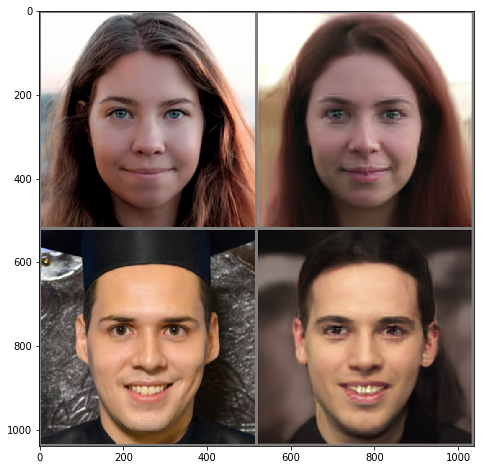

In [20]:
it = get_data_iterator(session, test_data_loader, 2, reso)

reconstruct_running(session,it)

## Random sampling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


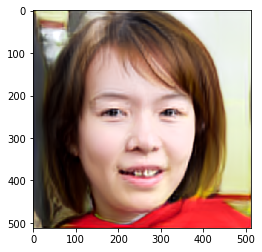

In [21]:
imgs = random_faces(session, 12345678, 3)
show(imgs[2])

## Style mixing

In [42]:
def mix(z, modifier_z, modifier_scale_range):
    style_layer_begin, style_layer_end = modifier_scale_range
    return utils.gen_seq([ (z, 0, style_layer_begin), 
                    (modifier_z, style_layer_begin, style_layer_end),
                    (z, style_layer_end, -1),
    ], session.g_running, session).detach()
    
img,_ = next(it)
z = encode(session, img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FULL Reconstruction


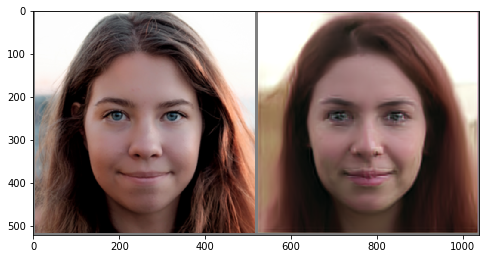

In [43]:
z1 = z[0].unsqueeze(0)
z2 = z[1].unsqueeze(0)

full_reco = mix(z1, z2, (-1,-1))
show_pairs(img[0].unsqueeze(0), full_reco[0].unsqueeze(0));

print('FULL Reconstruction')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Drive coarse features (4x4 to 8x8) of the bottom-left image BY the top-right


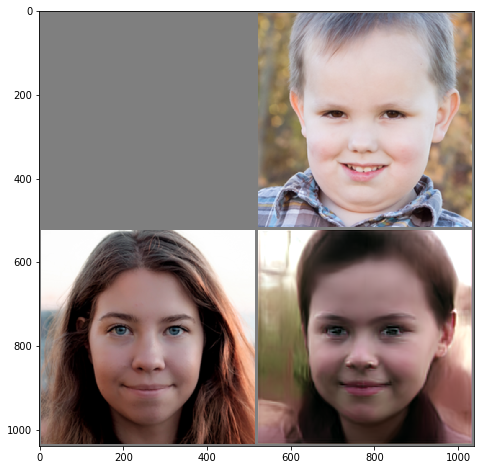

In [44]:
mixed = mix(z1, z2, (0,2))
show_mix(img[0].unsqueeze(0), mixed.unsqueeze(0), img[1], reso);
print('Drive coarse features (4x4 to 8x8) of the bottom-left image BY the top-right')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Drive intermediate features (16x16 to 64x64) of the bottom-left image BY the top-right


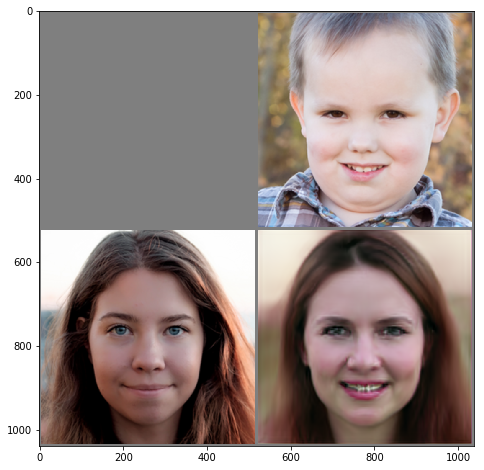

In [45]:
mixed = mix(z1, z2, (2,5))
show_mix(img[0].unsqueeze(0), mixed.unsqueeze(0), img[1], reso);
print('Drive intermediate features (16x16 to 64x64) of the bottom-left image BY the top-right')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Drive fine-grained features (128x128+) of the bottom-left image BY the top-right


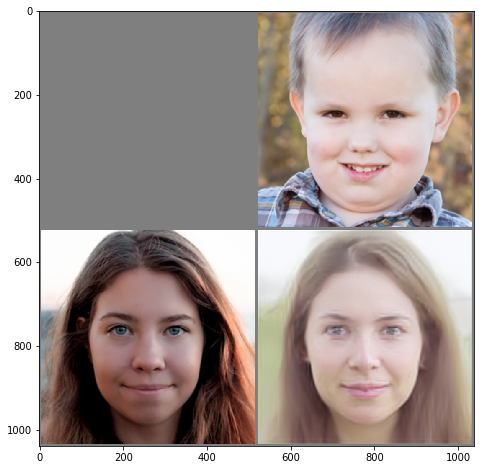

In [46]:
mixed = mix(z1, z2, (5,-1))
show_mix(img[0].unsqueeze(0), mixed.unsqueeze(0), img[1], reso);
print('Drive fine-grained features (128x128+) of the bottom-left image BY the top-right')

Drive coarse features (4x4 to 8x8) of the bottom-left image BY the top-right


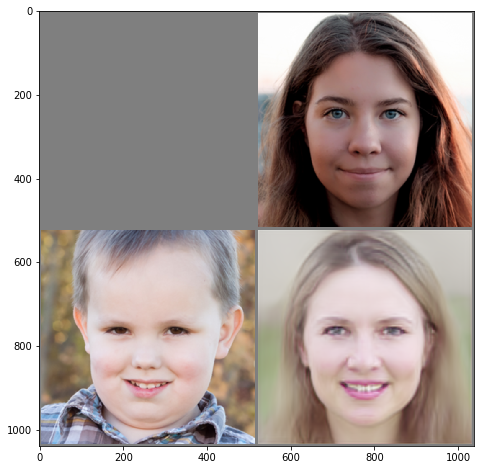

In [47]:
mixed = mix(z2, z1, (0,2))
show_mix(img[1].unsqueeze(0), mixed.unsqueeze(0), img[0], reso);
print('Drive coarse features (4x4 to 8x8) of the bottom-left image BY the top-right')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Drive intermediate features (16x16 to 64x64) of the bottom-left image BY the top-right


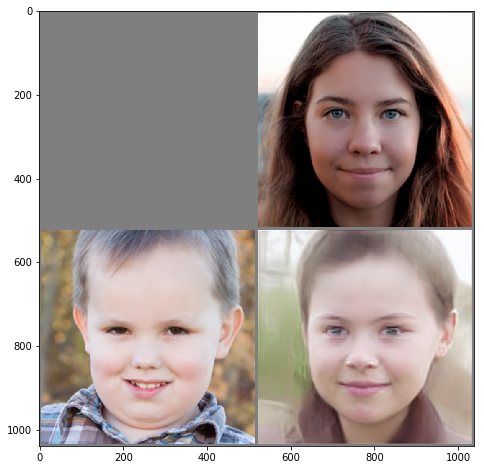

In [48]:
mixed = mix(z2, z1, (2,5))
show_mix(img[1].unsqueeze(0), mixed.unsqueeze(0), img[0], reso);
print('Drive intermediate features (16x16 to 64x64) of the bottom-left image BY the top-right')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Drive fine-grained features (128x128+) of the bottom-left image BY the top-right


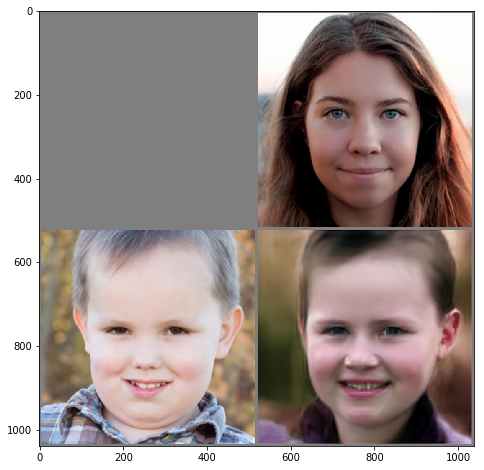

In [49]:
mixed = mix(z2, z1, (5,-1))
show_mix(img[1].unsqueeze(0), mixed.unsqueeze(0), img[0], reso);
print('Drive fine-grained features (128x128+) of the bottom-left image BY the top-right')

## Attribute Manipulation

In [50]:
smile_delta = torch.load('pioneer/attrib/smile_delta512') #For 256x256, use 'smile_delta2'

In [51]:
alpha = np.linspace(-3.0, 3.0, 60, dtype=np.float32)
alpha = torch.from_numpy(alpha).unsqueeze(1).cuda()

In [ ]:
it = get_data_iterator(session, test_data_loader, 2, 512)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


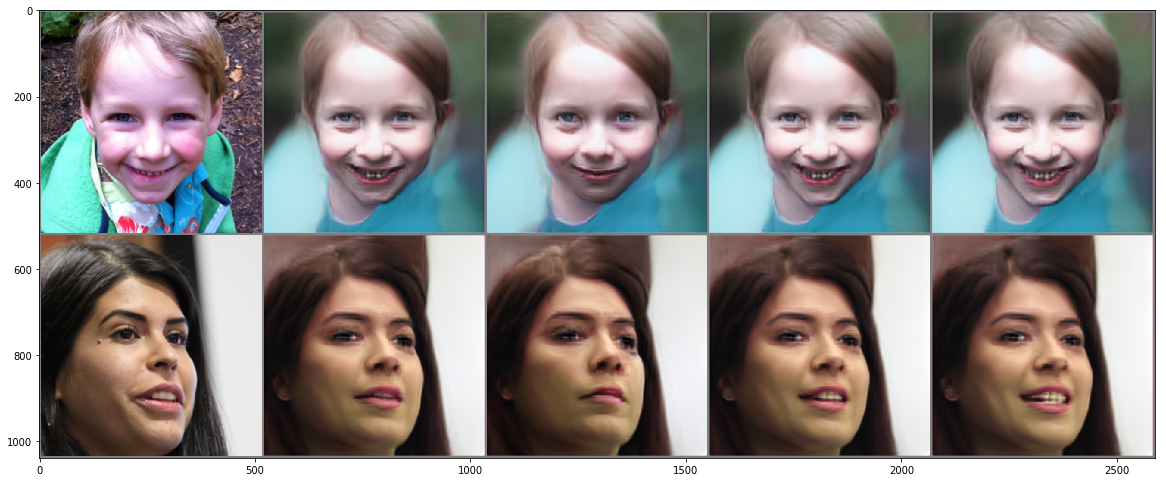

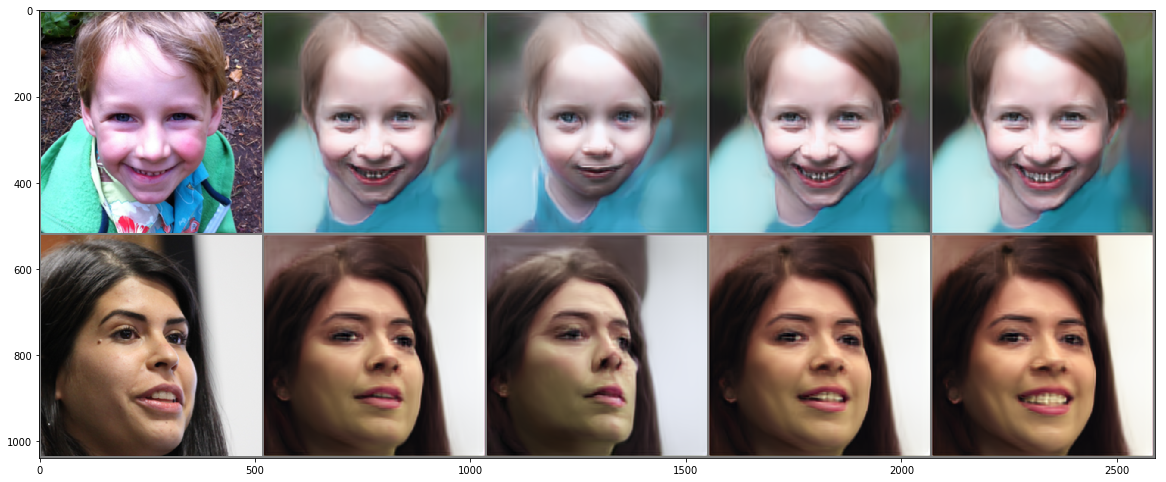

In [54]:
# Attribute manipulation: Smile
# The order of images is:
# 1. real image input, 2. the reconstruction, 3-5. manipulated with the attribute (see alpha)
# On the first 2 rows, attribute applies only to the intermediate layers
# On the last  2 rows, attribute applies to all layers

show_feat2(session, it, smile_delta, alphas = [-1.5, 0.5, 1.0])